<a href="https://colab.research.google.com/github/ishriana/Cohort-Analysis-/blob/main/Cohort_analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

In [79]:
df = pd.read_excel('/content/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Rearrainging the Dataframe

In [80]:
df1 = pd.DataFrame()

In [81]:
columns = ['InvoiceNo','InvoiceDate','CustomerID','StockCode','UnitPrice','Quantity','Description','Country']

In [82]:
df1 = df[columns]

In [83]:
df1.head()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,UnitPrice,Quantity,Description,Country
0,536365,2010-12-01 08:26:00,17850.0,85123A,2.55,6,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,2010-12-01 08:26:00,17850.0,71053,3.39,6,WHITE METAL LANTERN,United Kingdom
2,536365,2010-12-01 08:26:00,17850.0,84406B,2.75,8,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,2010-12-01 08:26:00,17850.0,84029G,3.39,6,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,2010-12-01 08:26:00,17850.0,84029E,3.39,6,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [84]:
df1['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [85]:
df1['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [86]:
duration = df1['InvoiceDate'].max() - df1['InvoiceDate'].min()
duration

Timedelta('373 days 04:24:00')

Dataset has records of almost a year

In [87]:
df1.shape

(541909, 8)

In [88]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   InvoiceDate  541909 non-null  datetime64[ns]
 2   CustomerID   406829 non-null  float64       
 3   StockCode    541909 non-null  object        
 4   UnitPrice    541909 non-null  float64       
 5   Quantity     541909 non-null  int64         
 6   Description  540455 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [89]:
df1.isnull().sum()

InvoiceNo           0
InvoiceDate         0
CustomerID     135080
StockCode           0
UnitPrice           0
Quantity            0
Description      1454
Country             0
dtype: int64

Customer_id has a lot of missing values. Since this column is important for doing analysis and cant have duplicate id's we will drop the rows with null values

In [90]:
df1 = df1.dropna()

In [91]:
df1.isnull().sum()

InvoiceNo      0
InvoiceDate    0
CustomerID     0
StockCode      0
UnitPrice      0
Quantity       0
Description    0
Country        0
dtype: int64

So basically this cleans our dataset at the cost of loosing some chunk of information but its worth the deal. If you have better solutions please feel free to post it in the comments section

In [92]:
df1.tail()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,UnitPrice,Quantity,Description,Country
541904,581587,2011-12-09 12:50:00,12680.0,22613,0.85,12,PACK OF 20 SPACEBOY NAPKINS,France
541905,581587,2011-12-09 12:50:00,12680.0,22899,2.10,6,CHILDREN'S APRON DOLLY GIRL,France
541906,581587,2011-12-09 12:50:00,12680.0,23254,4.15,4,CHILDRENS CUTLERY DOLLY GIRL,France
541907,581587,2011-12-09 12:50:00,12680.0,23255,4.15,4,CHILDRENS CUTLERY CIRCUS PARADE,France
541908,581587,2011-12-09 12:50:00,12680.0,22138,4.95,3,BAKING SET 9 PIECE RETROSPOT,France


From the table it is evident that a single customer has placed multiple orders. so we will create a variable storing values of the count of orders placed per customer

In [93]:
n_orders = df1.groupby(['CustomerID'])['InvoiceDate'].nunique()
n_orders

CustomerID
12346.0     2
12347.0     7
12348.0     4
12349.0     1
12350.0     1
           ..
18280.0     1
18281.0     1
18282.0     3
18283.0    16
18287.0     3
Name: InvoiceDate, Length: 4372, dtype: int64

In [94]:
np.sum(n_orders > 1)

3058

There are some orders that have values less than 1 which refers to returns or calcelled orders. we will try to get rid of this by removing the calcelled order and keeping the initial placement which in a way would make sense when we calculate our retention matrix.

Next we ll calculate the percentage of multiple orders as in how many people ordered more than once.

In [95]:
mult_order_per = (np.sum(n_orders>1)/len(n_orders))*100
mult_order_per

69.94510521500457

Almost 70% of the customers have ordered more than once.This piece of information leads to a hypothetical conclusion that we would have more retention rate 

In [96]:
#df = df[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

In [97]:
df1.shape

(406829, 8)

In [98]:
df1.duplicated(subset=['InvoiceNo']).sum()

384639

Above two columns represent duplicate values in invoice. To conclude these are the same invoice but might have multiple objects in them so values are repeating. we can just extract the invoice no for a customer by removing duplicates and yes that serves our purpose coz we are only interested in the visit of customer here not the volume of material sold. 

Also lets get rid of unwanted columns to keep track of our work neatly

In [107]:
df1 = df1[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

In [108]:
df1.shape

(22221, 3)

Create a new column having values of transaction by month

In [109]:
df1['order_month'] = df1['InvoiceDate'].dt.to_period('M')

In [111]:
df1.head()

,CustomerID,InvoiceNo,InvoiceDate,order_month
0,17850.0,536365,2010-12-01 08:26:00,2010-12
7,17850.0,536366,2010-12-01 08:28:00,2010-12
9,13047.0,536367,2010-12-01 08:34:00,2010-12
21,13047.0,536368,2010-12-01 08:34:00,2010-12
25,13047.0,536369,2010-12-01 08:35:00,2010-12


In [112]:
df1['Cohort'] = df1.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

In [117]:
df1.head()

,CustomerID,InvoiceNo,InvoiceDate,order_month,Cohort
0,17850.0,536365,2010-12-01 08:26:00,2010-12,2010-12
7,17850.0,536366,2010-12-01 08:28:00,2010-12,2010-12
9,13047.0,536367,2010-12-01 08:34:00,2010-12,2010-12
21,13047.0,536368,2010-12-01 08:34:00,2010-12,2010-12
25,13047.0,536369,2010-12-01 08:35:00,2010-12,2010-12


Next we will we aggregate the data per cohort and order_month and count the number of unique customers in each group. Also we add the period_number, which indicates the number of periods between the cohort month and the month of the purchase.

In [133]:
df1_cohort = df1.groupby(['Cohort','order_month']).agg(no_of_customers = ('CustomerID','nunique')).reset_index(drop=False)

In [134]:
df1_cohort

,Cohort,order_month,no_of_customers
0,2010-12,2010-12,948
1,2010-12,2011-01,362
2,2010-12,2011-02,317
3,2010-12,2011-03,367
4,2010-12,2011-04,341
...,...,...,...
86,2011-10,2011-11,93
87,2011-10,2011-12,46
88,2011-11,2011-11,321
89,2011-11,2011-12,43


In [136]:
df1_cohort['period'] = (df1_cohort['order_month'] - df1_cohort['Cohort']).apply(attrgetter('n'))

In [137]:
df1_cohort

,Cohort,order_month,no_of_customers,period
0,2010-12,2010-12,948,0
1,2010-12,2011-01,362,1
2,2010-12,2011-02,317,2
3,2010-12,2011-03,367,3
4,2010-12,2011-04,341,4
...,...,...,...,...
86,2011-10,2011-11,93,1
87,2011-10,2011-12,46,2
88,2011-11,2011-11,321,0
89,2011-11,2011-12,43,1


We ll change the alignment of this table by using pivot and viewing it in more informative way

In [138]:
cohort_pivot = df1_cohort.pivot_table(columns='period',index='Cohort',values='no_of_customers')

In [139]:
cohort_pivot

period,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To obtain the retention matrix we ll do some math. Divide a value by its total. 

In [140]:
cohort_size = cohort_pivot.iloc[:,0]

In [141]:
cohort_size

Cohort
2010-12    948.0
2011-01    421.0
2011-02    380.0
2011-03    440.0
2011-04    299.0
2011-05    279.0
2011-06    235.0
2011-07    191.0
2011-08    167.0
2011-09    298.0
2011-10    352.0
2011-11    321.0
2011-12     41.0
Freq: M, Name: 0, dtype: float64

In [145]:
retention_matrix = cohort_pivot.divide(cohort_size,axis=0)

In [146]:
retention_matrix

period,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]), <a list of 13 Text major ticklabel objects>)

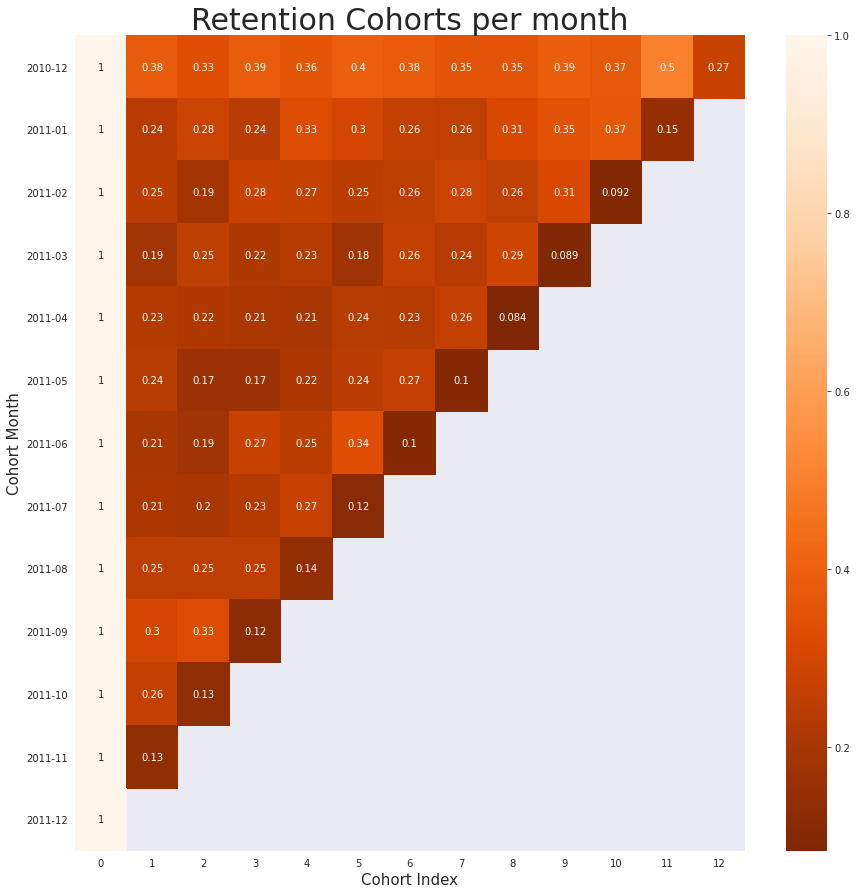

In [152]:
sns.set_style('darkgrid')
plt.figure(figsize = (15,15))
sns.heatmap(retention_matrix,annot=True,cmap='Oranges_r')
plt.xlabel('Cohort Index', fontsize=15)
plt.ylabel('Cohort Month',fontsize=15)
plt.title('Retention Cohorts per month', fontsize=30)
plt.yticks(rotation='360')